In [5]:
import pdb
from functools import partial
from typing import Callable

import einops
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import PRNGKeyArray, PyTreeDef
from tqdm import tqdm

from diffuse.mixture import init_mixture, sampler_mixtr
from diffuse.neural_networks import MLP
from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, LinearSchedule, SDEState
from diffuse.unet import UNet
#from diffuse.conditional import generate_cond_sample, pmcmc, pmcmc_step, CondSDE
from diffuse.images import measure, SquareMask, restore

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]

xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")

tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=tf)
sde = SDE(beta)

nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")

In [7]:
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
nn_params = nn_trained["params"].item()
# nn_params = nn_unet.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size, )))
array_param, array_to_dict = jax.flatten_util.ravel_pytree(nn_params)

# test other implementation
# nn_trained = jnp.load("mnist_lin_2999.npz", allow_pickle=True)
# nn_params = nn_trained["param"]
# nn_params = array_to_dict(nn_params)

In [8]:
def nn_score(x, t):
    return nn_unet.apply(nn_params, x, t)

In [10]:
n_steps = 100
rng_key = jax.random.PRNGKey(0)

ts = jnp.array([tf])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

init_samples = jax.random.normal(rng_key, data[0].shape)
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)
state_0, state_Ts = revert_sde(rng_key, state_f)

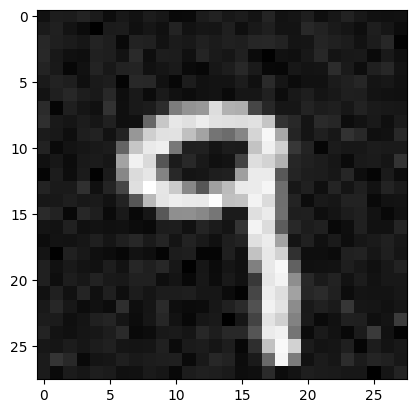

In [11]:
plt.imshow(state_Ts.position[-1], cmap="gray")
plt.show()

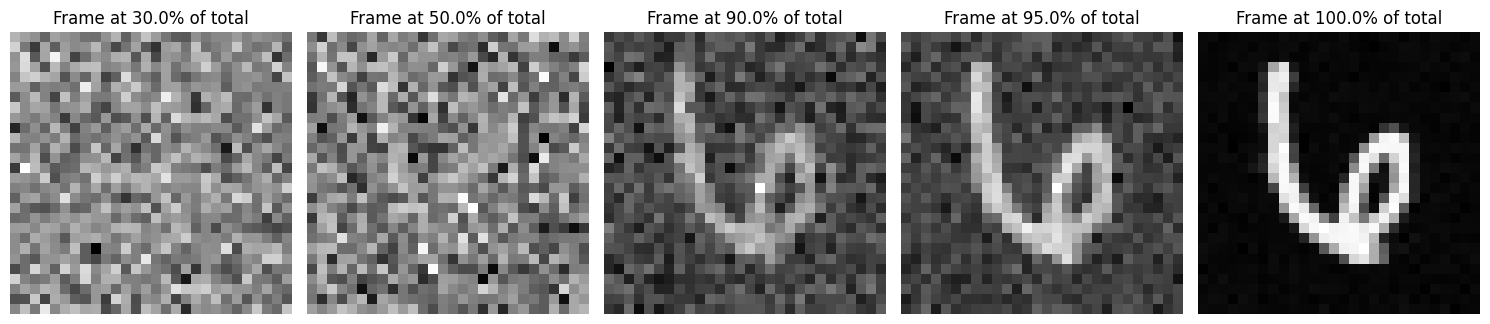

In [11]:
total_frames = len(state_Ts.position)

# Define the fractions
fractions = [0.3, 0.5, 0.9, 0.95, 1.0]

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for idx, fraction in enumerate(fractions):
    # Calculate the frame index
    frame_index = int(fraction * total_frames)

    # Plot the image
    axs[idx].imshow(state_Ts.position[frame_index], cmap="gray")
    axs[idx].set_title(f"Frame at {fraction*100}% of total")
    axs[idx].axis("off")  # Turn off axis labels

plt.tight_layout()
plt.show()

In [9]:
x = xs[0]
mask = SquareMask(10, x.shape)
# x = state_Ts.position[-1]
xi = jnp.array([10.0, 20.0])
y = measure(xi, x, mask)
cond_sde = CondSDE(beta=beta, mask=mask, tf=2.0, score=nn_score)

res = generate_cond_sample(y, xi, key, 100, cond_sde, x.shape)

ScopeParamShapeError: Initializer expected to generate shape (7, 7, 1, 64) but got shape (7, 7, 28, 64) instead for parameter "kernel" in "/init.conv_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [2]:
import jax
import jax.numpy as jnp
from diffuse.sde import SDE, LinearSchedule
from diffuse.images import SquareMask, measure
from diffuse.conditional import CondSDE
from diffuse.filter import generate_cond_sample
from diffuse.unet import UNet
import numpy as np

# Load MNIST dataset
data = np.load("dataset/mnist.npz")
xs = jnp.array(data["X"])
xs = xs.reshape(xs.shape[0], xs.shape[1], xs.shape[2], 1)  # Add channel dimension
batch_size = 2
tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t

# Initialize PRNGKey
key = jax.random.PRNGKey(0)

# Define beta schedule
beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)

# Initialize ScoreNetwork (assuming you have this defined elsewhere)
score_net = UNet(dt, 64, upsampling="pixel_shuffle")
#params = score_net.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size,)))
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
params = nn_trained["params"].item()


# Define neural network score function
def nn_score(x, t):
    return score_net.apply(params, x, t)


# SDE setup
sde = SDE(beta=beta)


x = xs[0]
mask = SquareMask(10, x.shape)
# x = state_Ts.position[-1]
xi = jnp.array([10.0, 20.0])
y = measure(xi, x, mask)
cond_sde = CondSDE(beta=beta, mask=mask, tf=2.0, score=nn_score)

#res = generate_cond_sample(y, xi, key, 500, cond_sde, x.shape)


In [22]:
res = generate_cond_sample(y, xi, key, 5, cond_sde, x.shape)

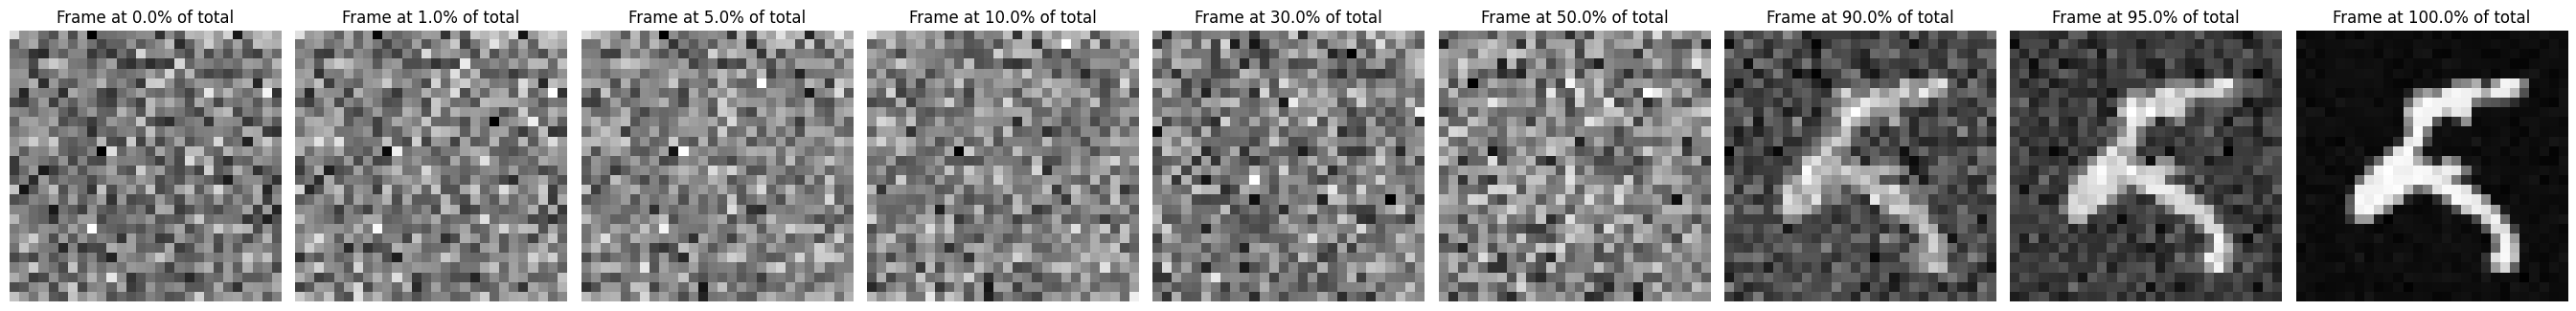

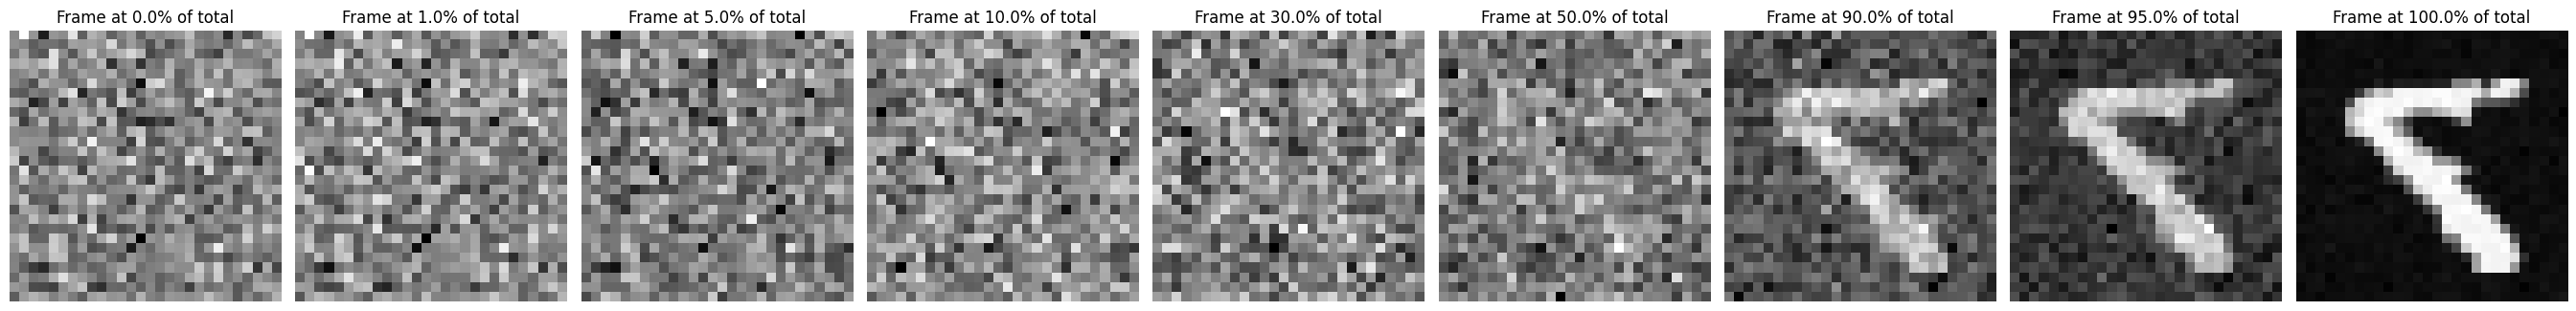

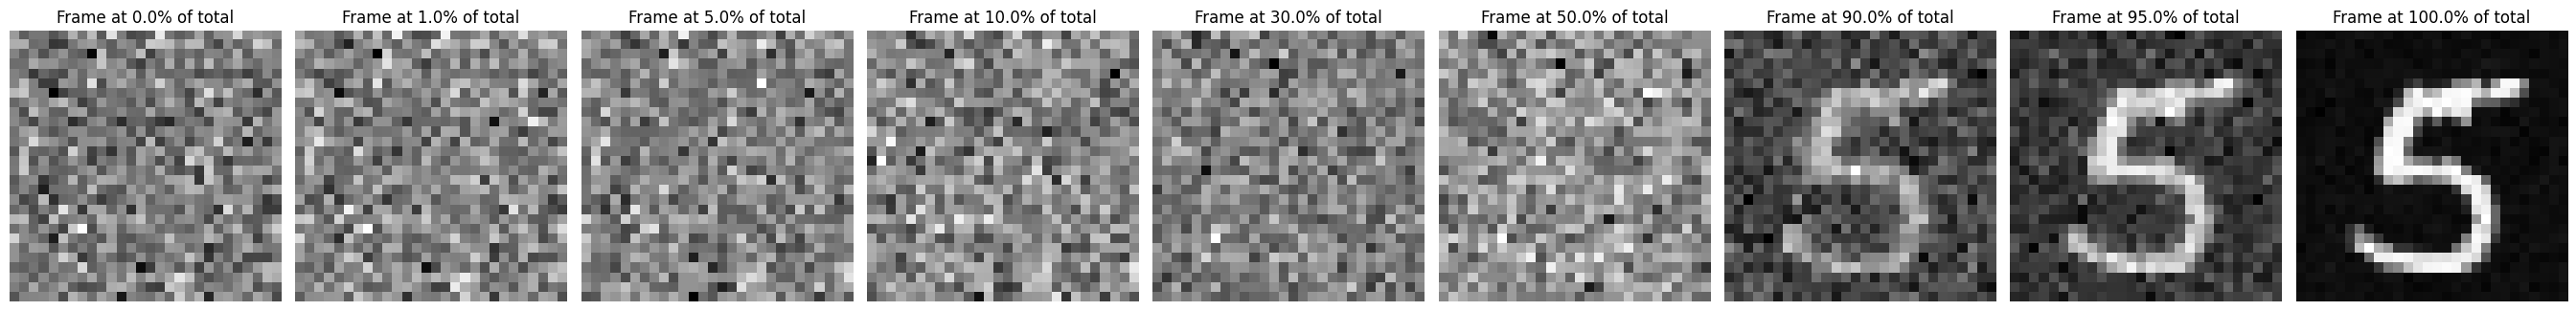

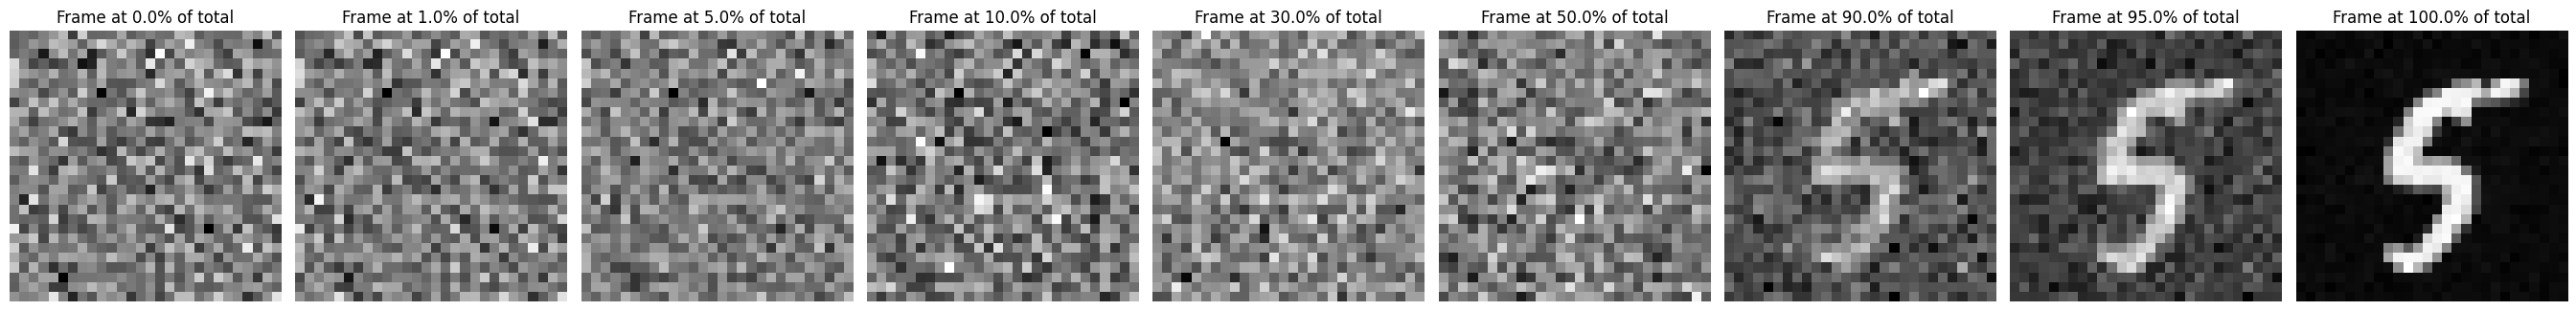

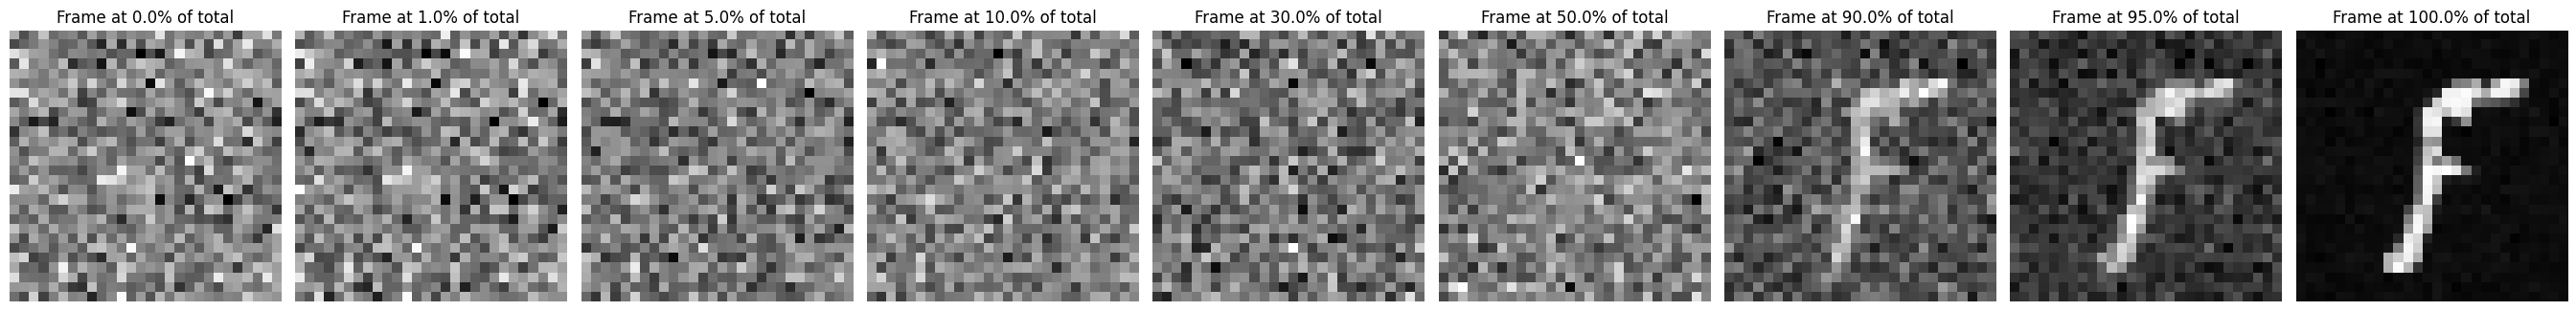

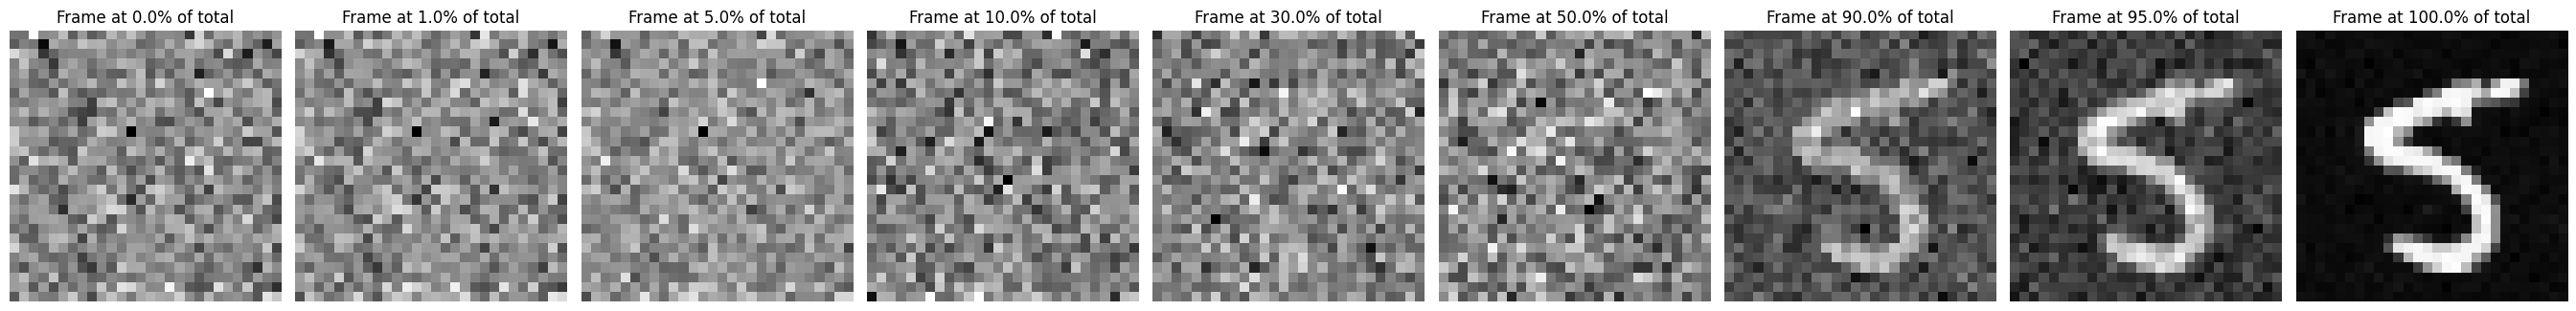

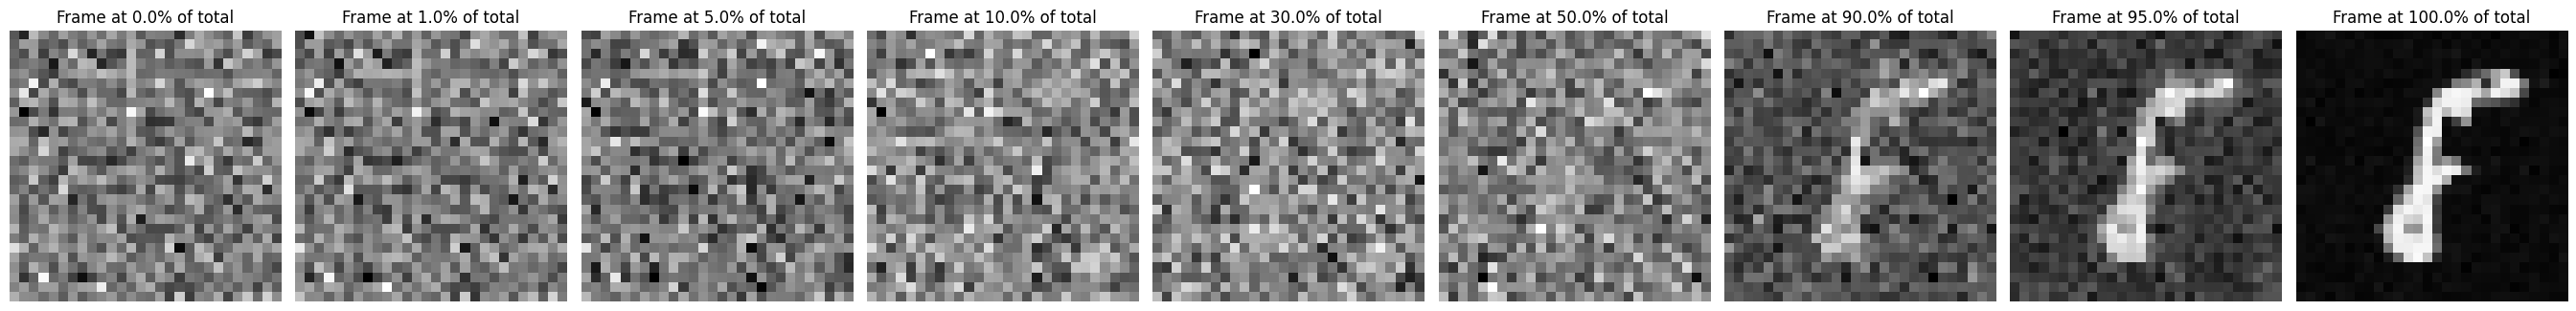

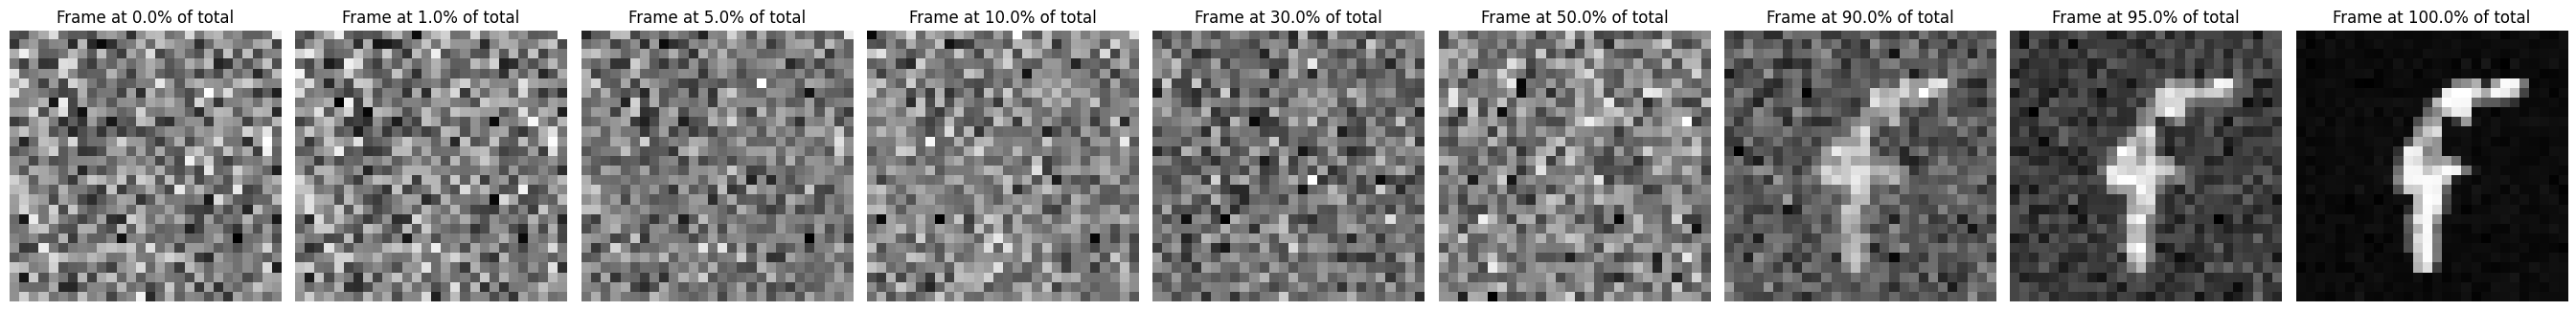

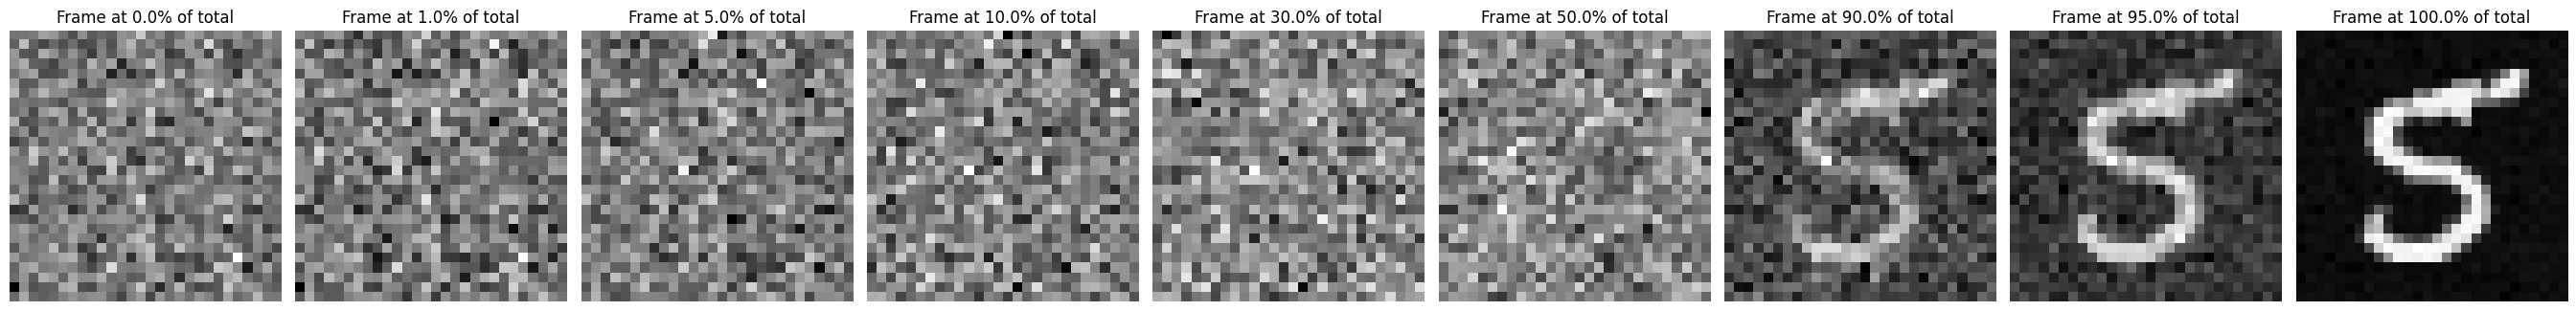

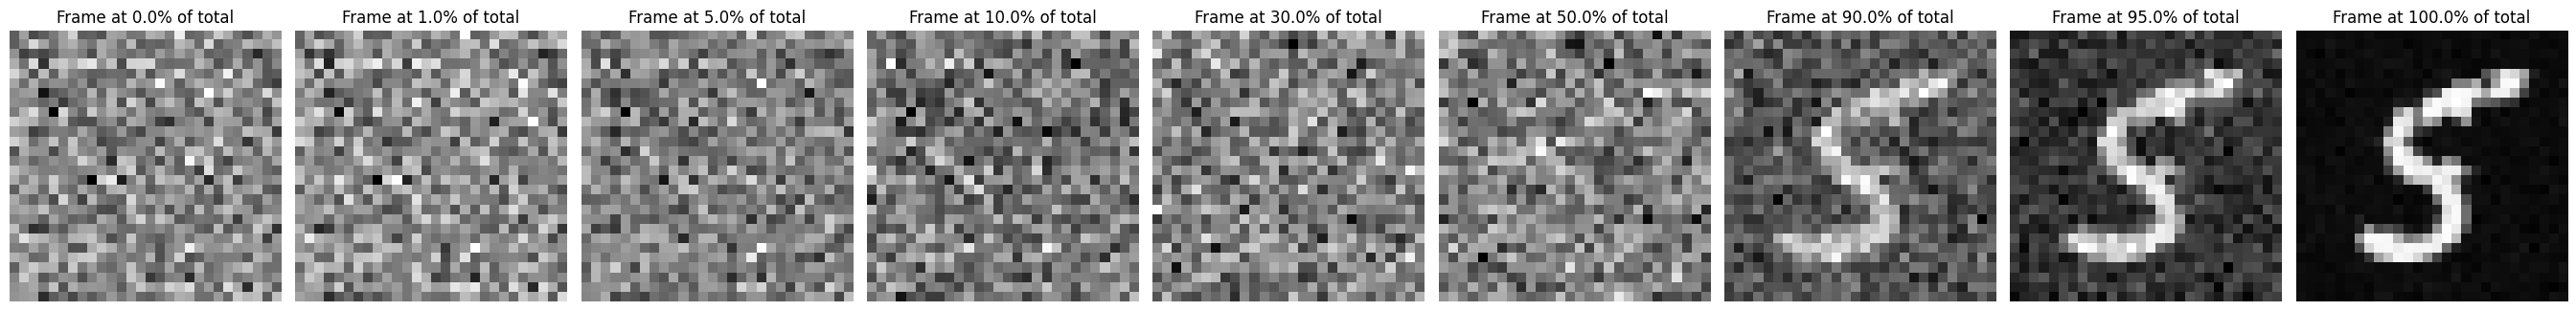

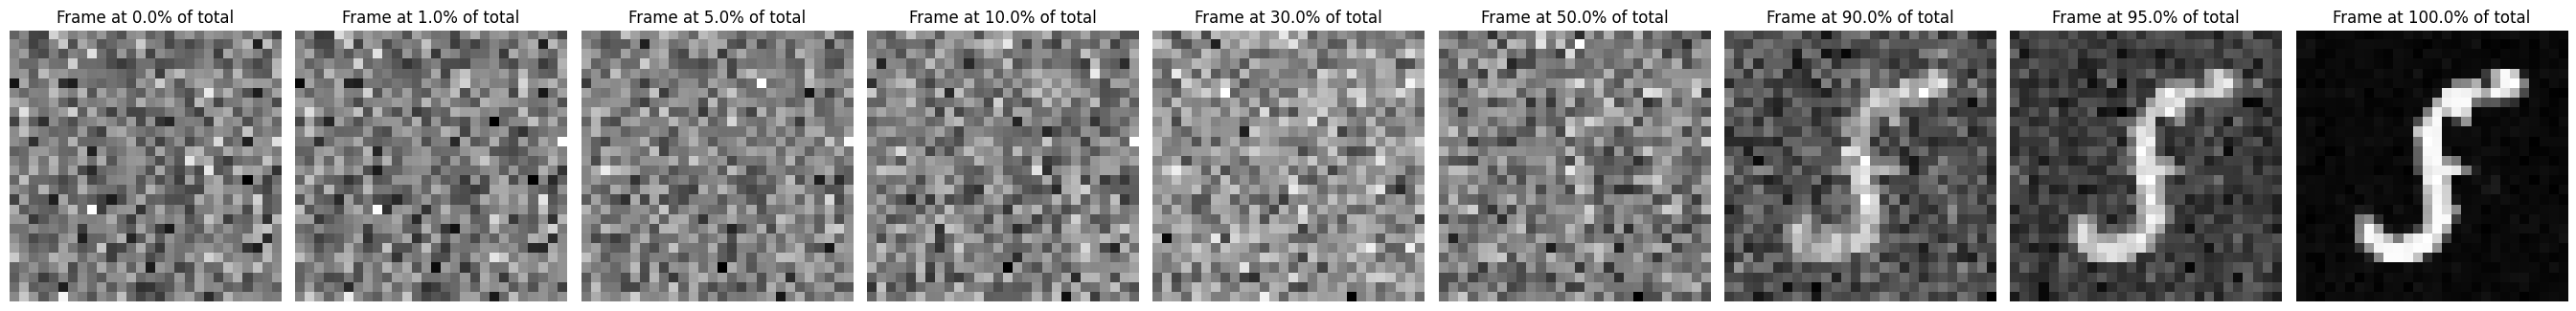

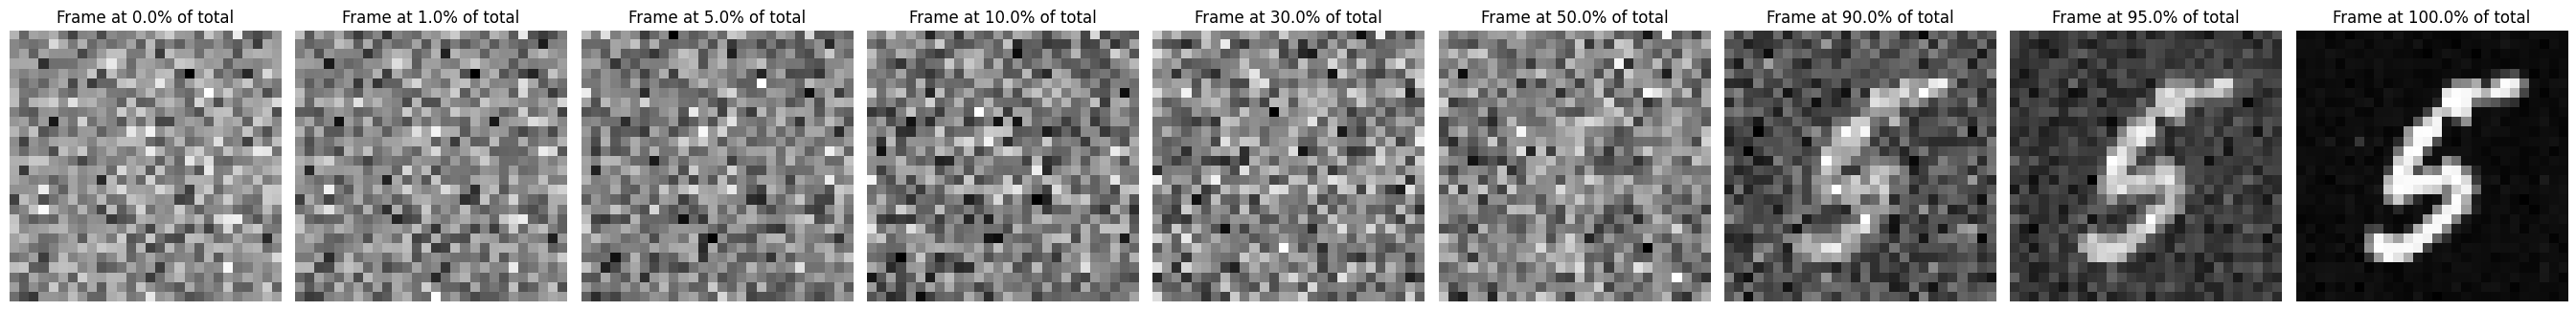

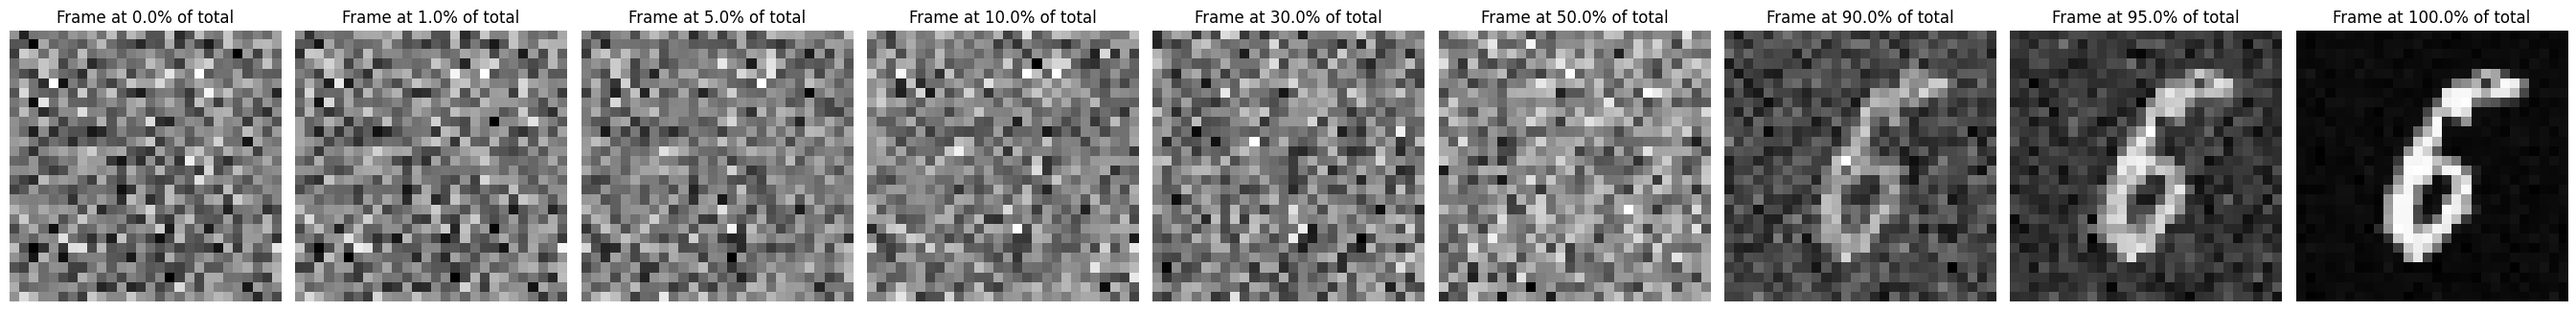

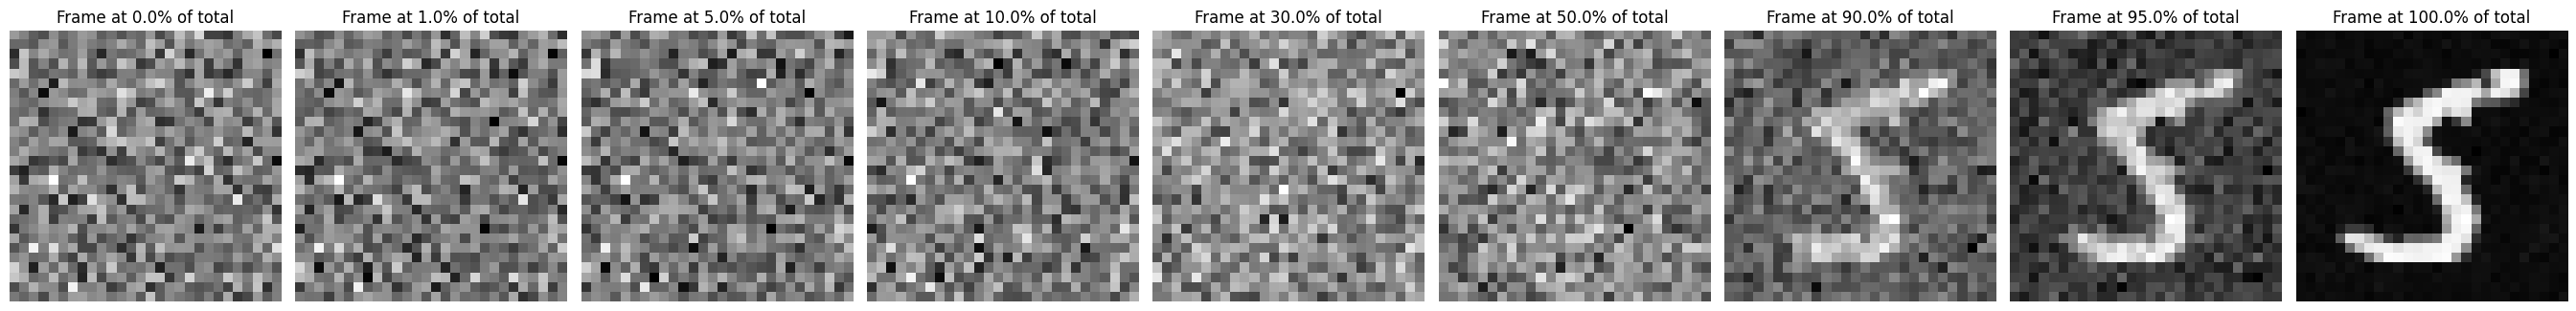

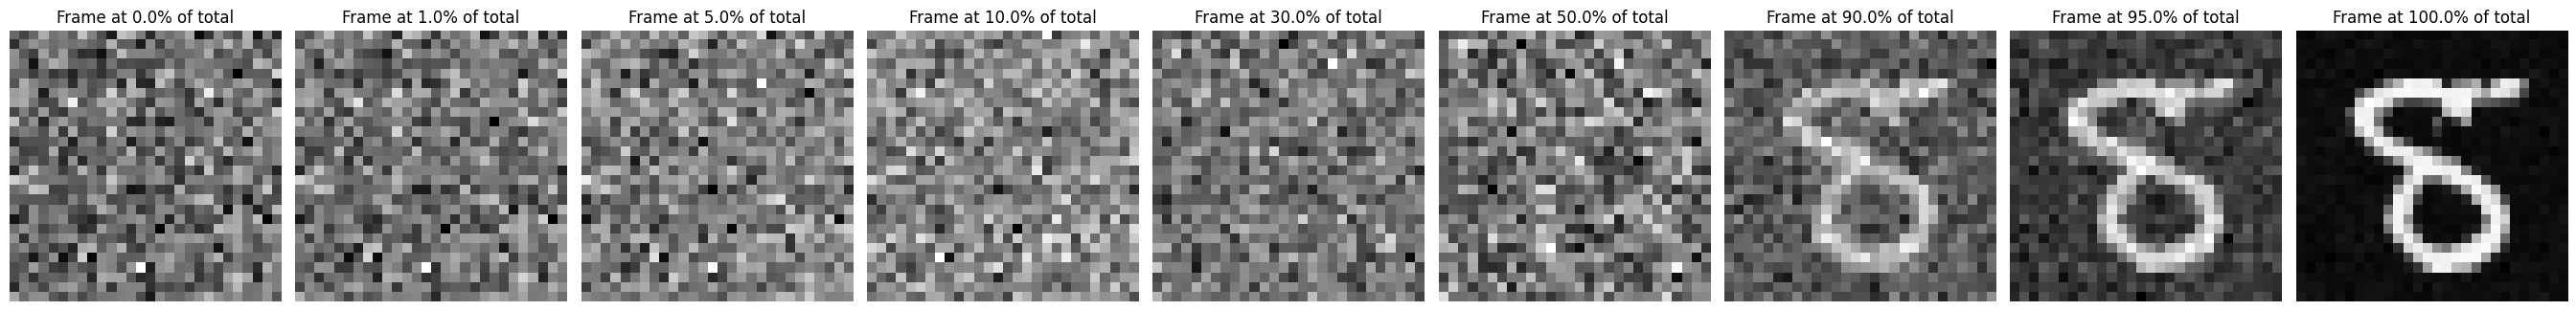

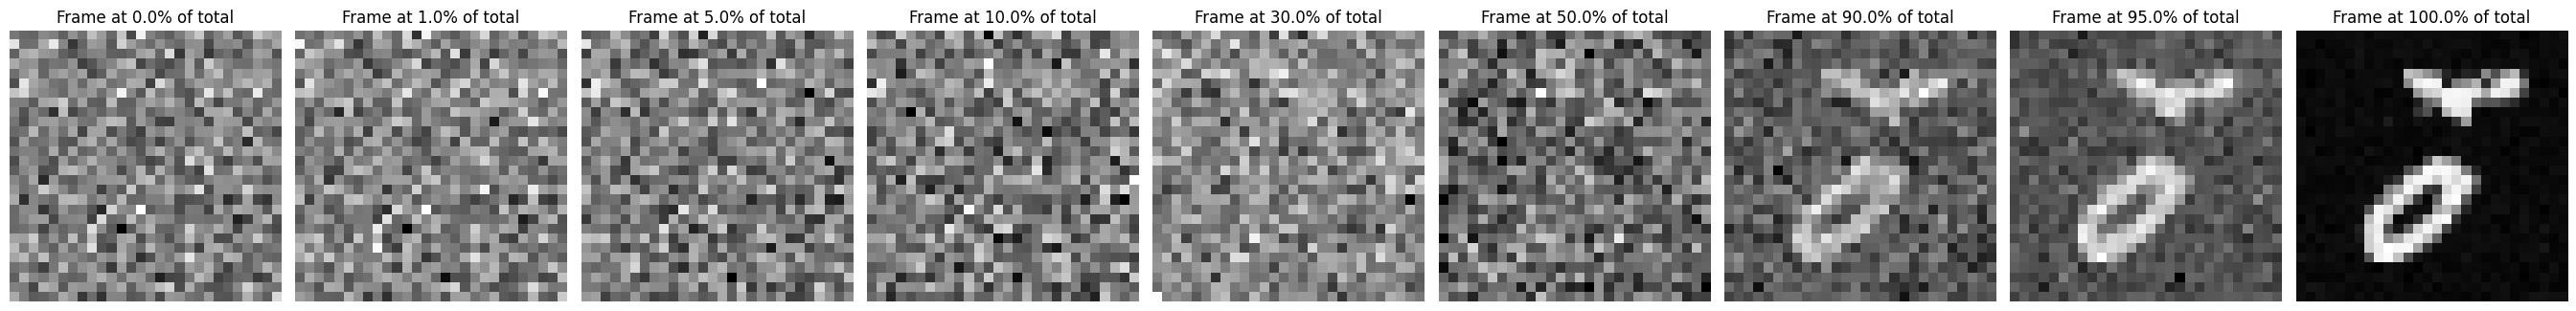

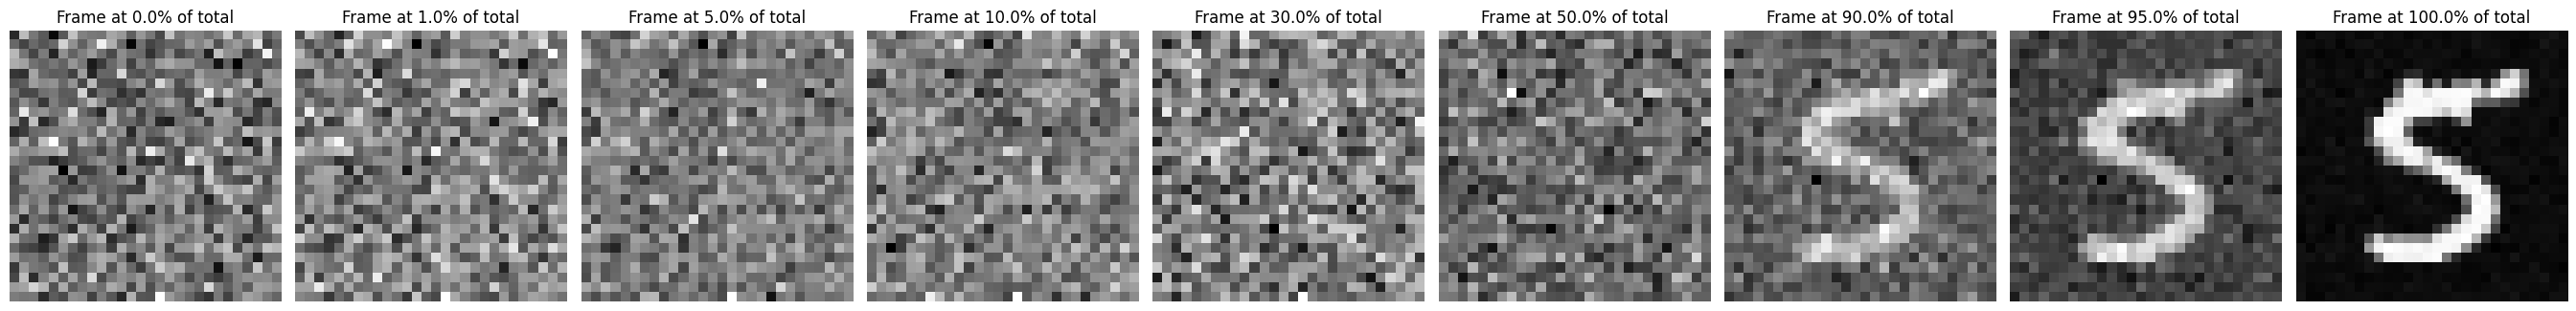

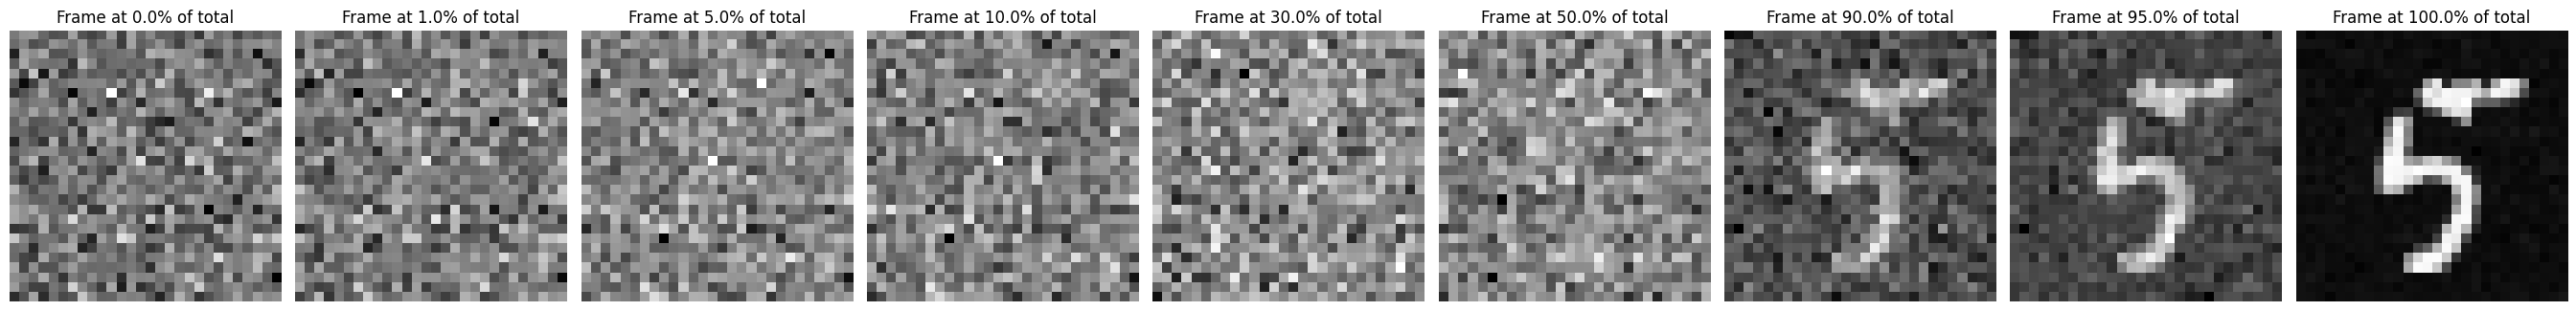

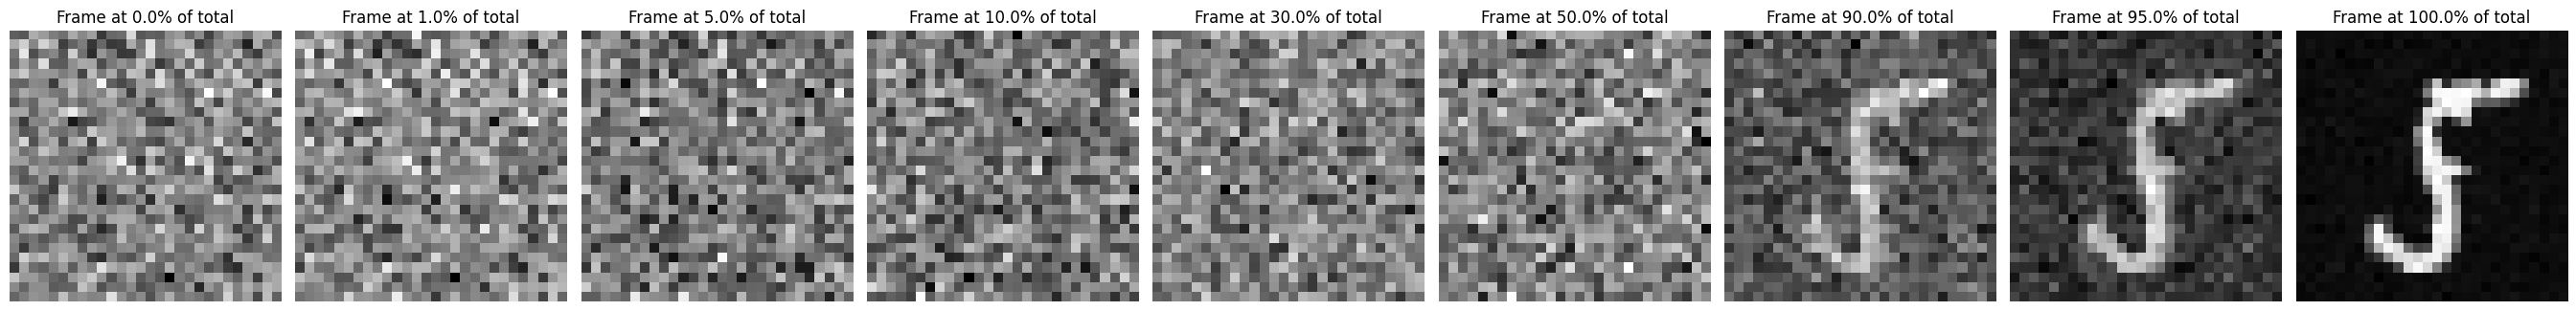

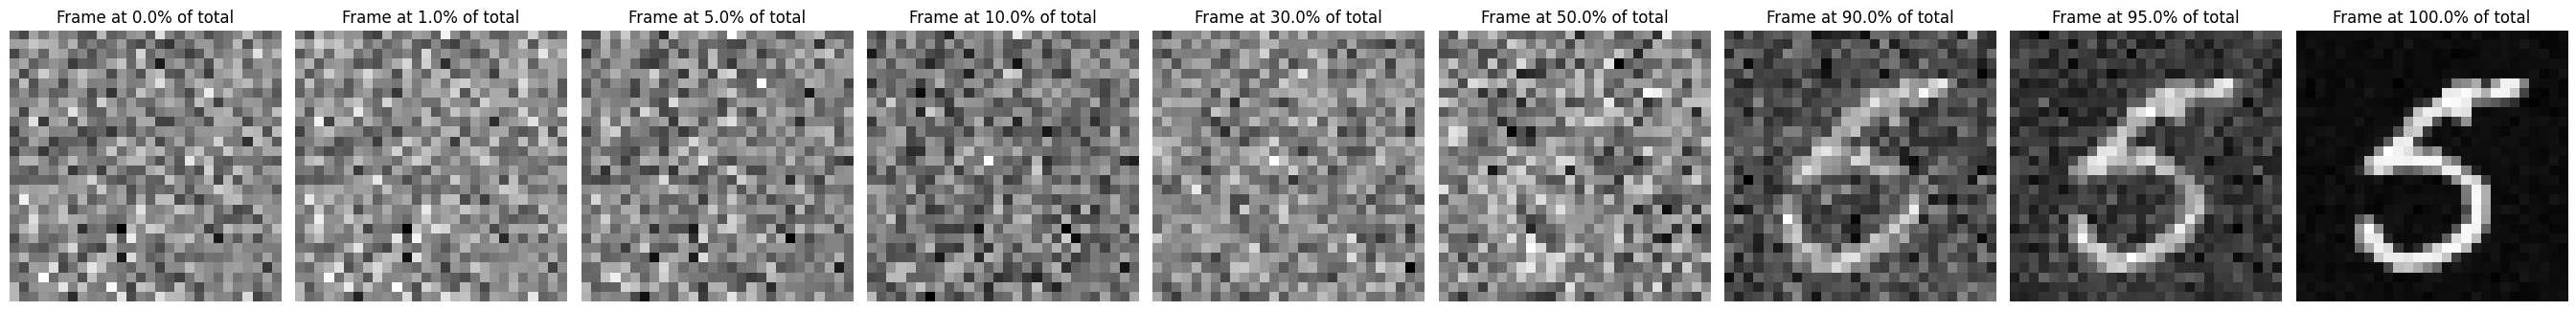

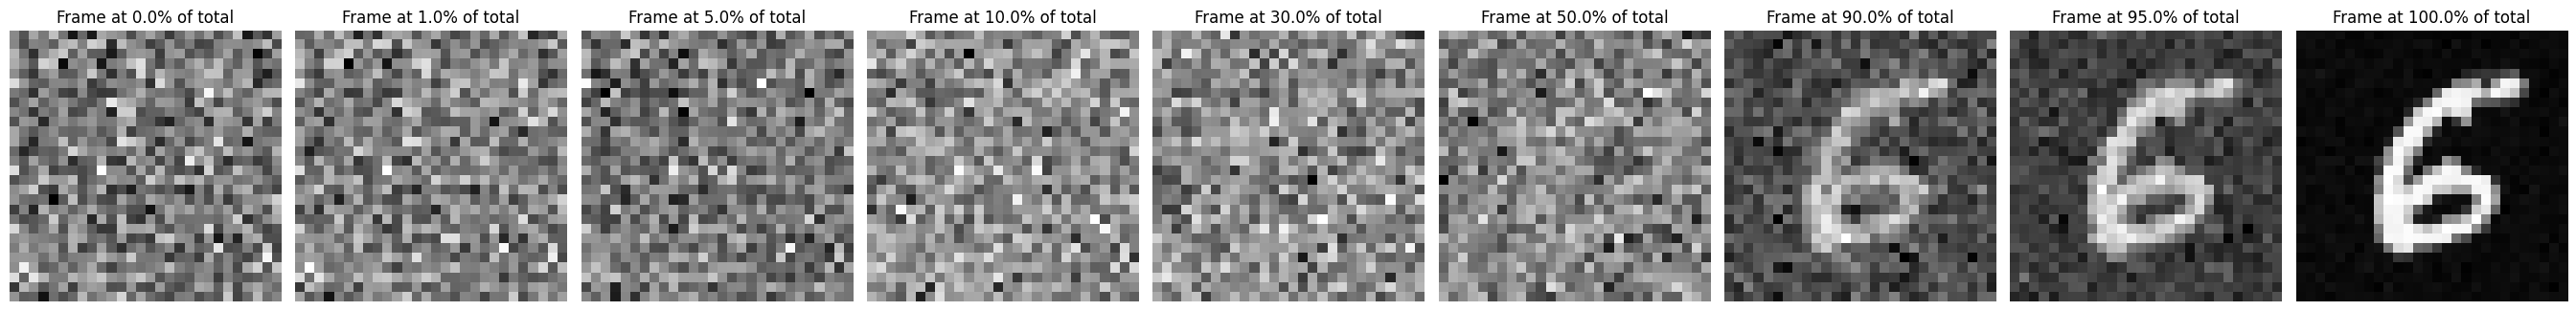

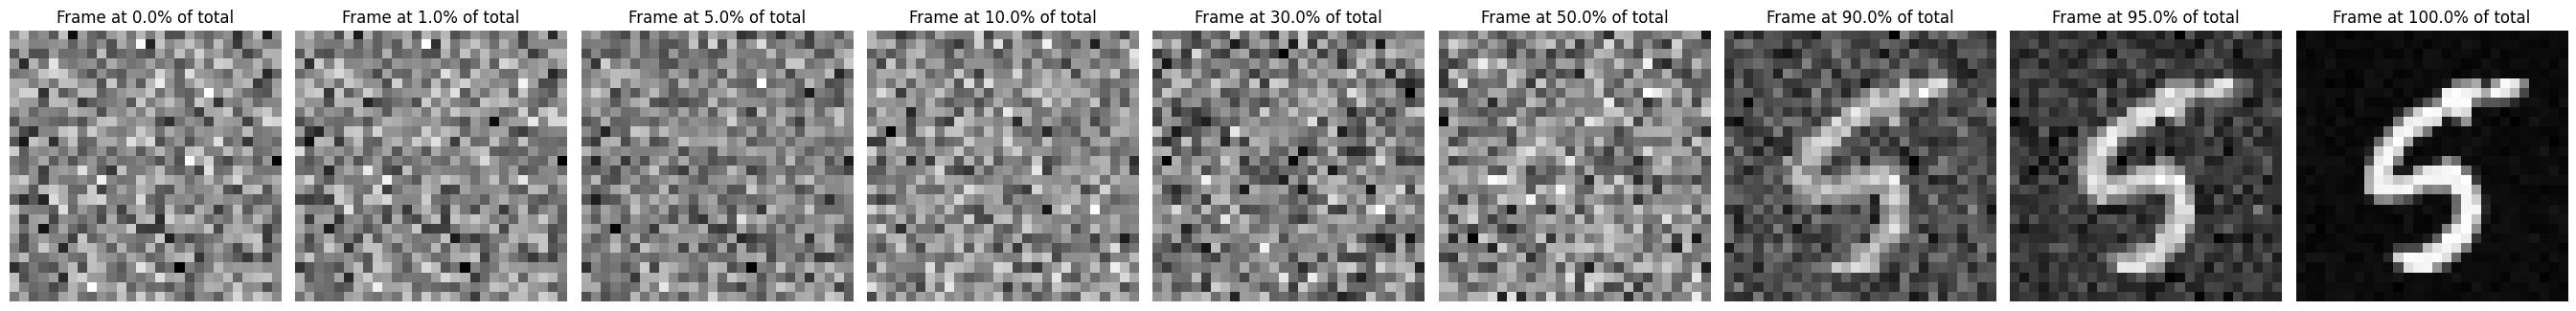

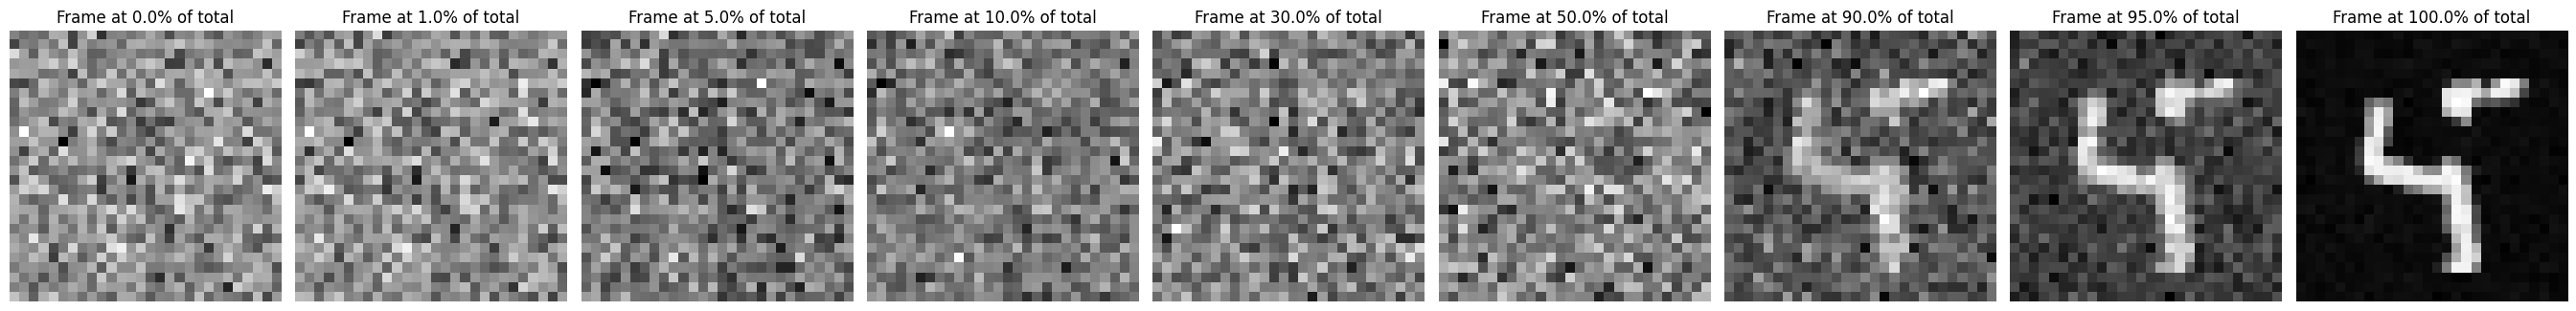

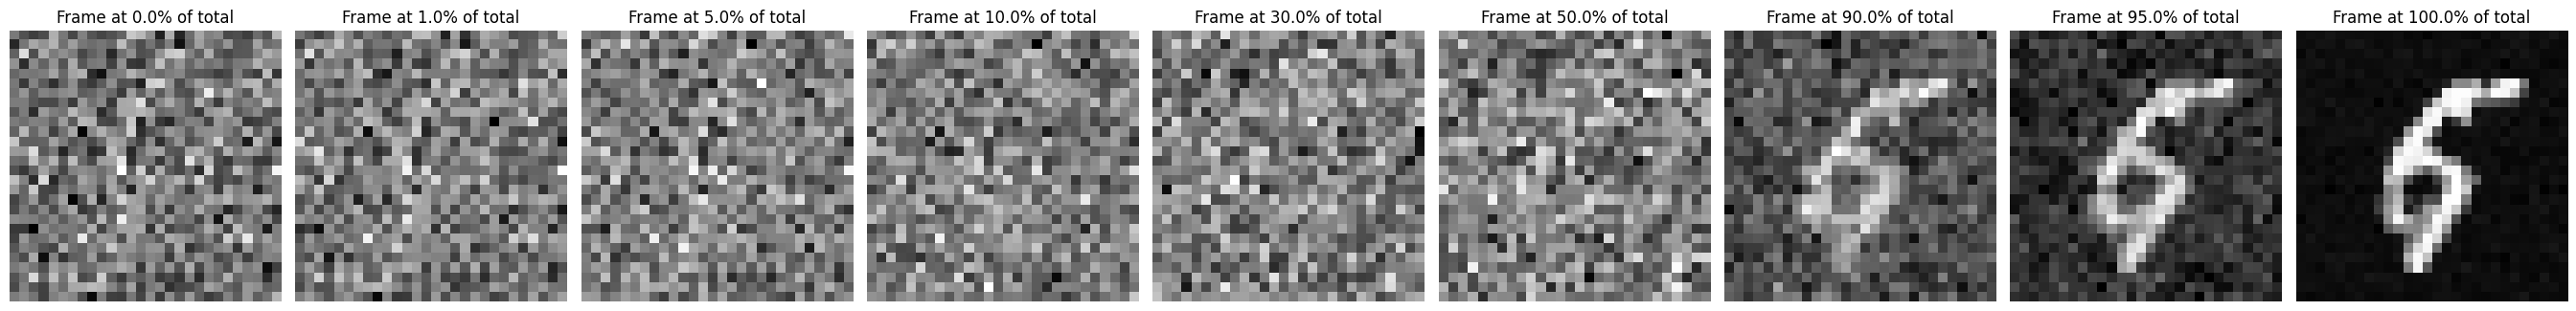

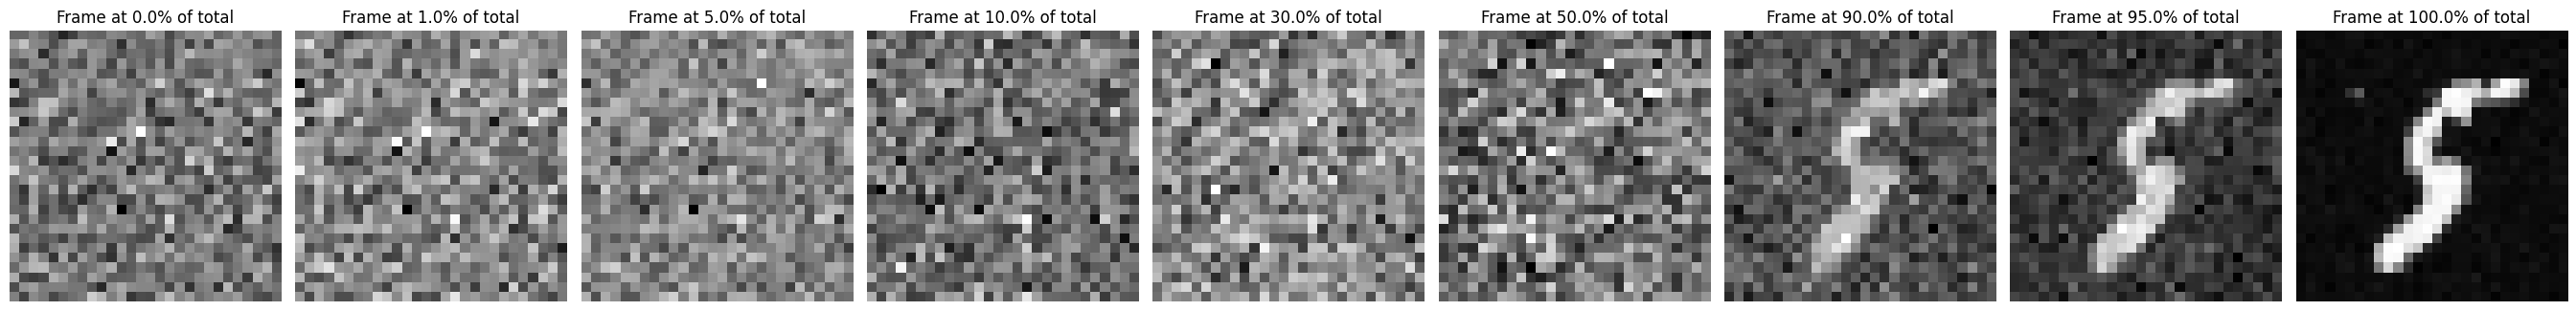

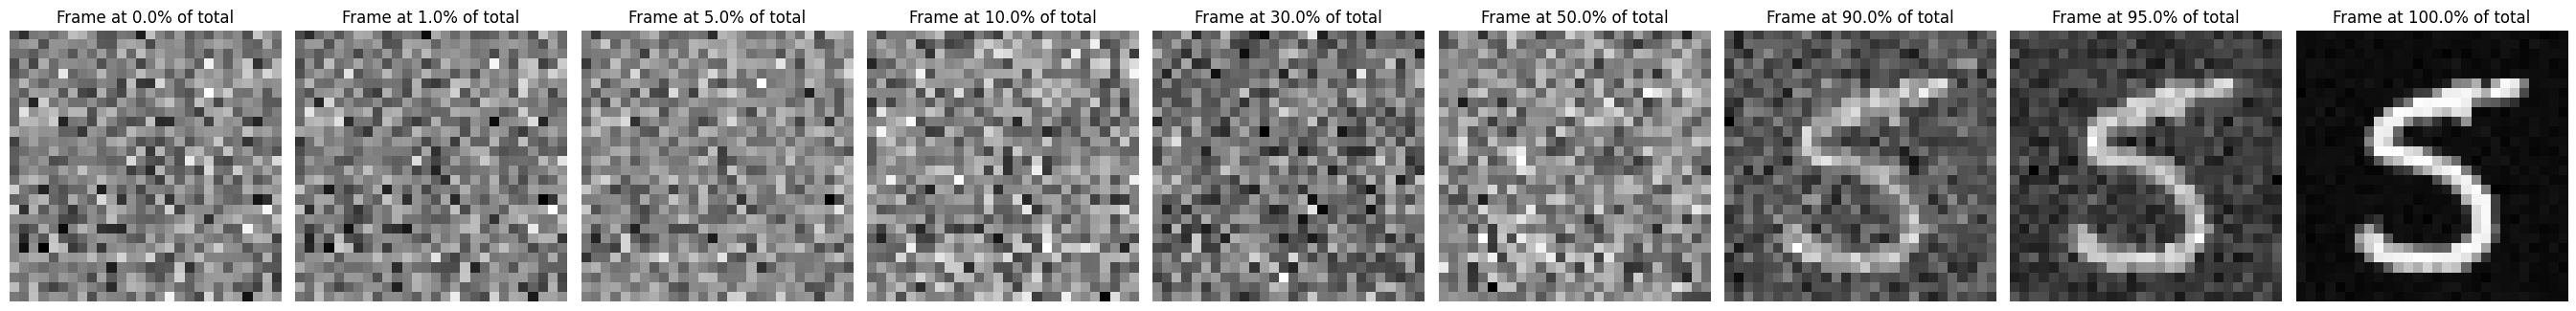

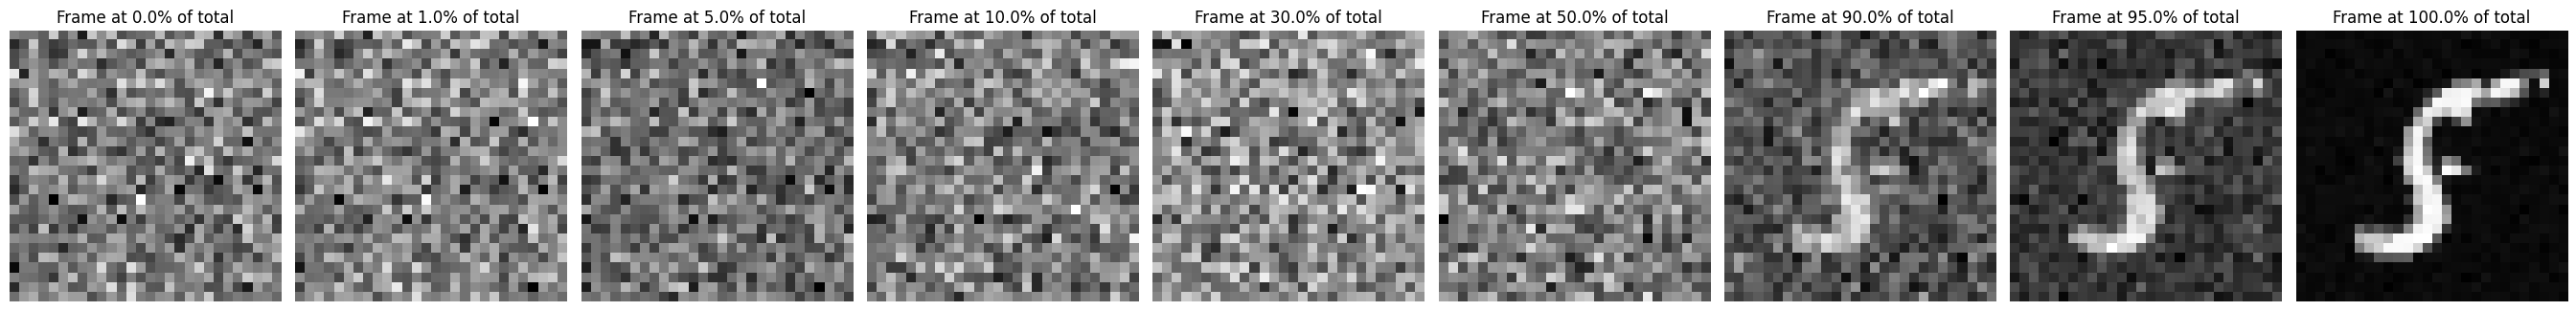

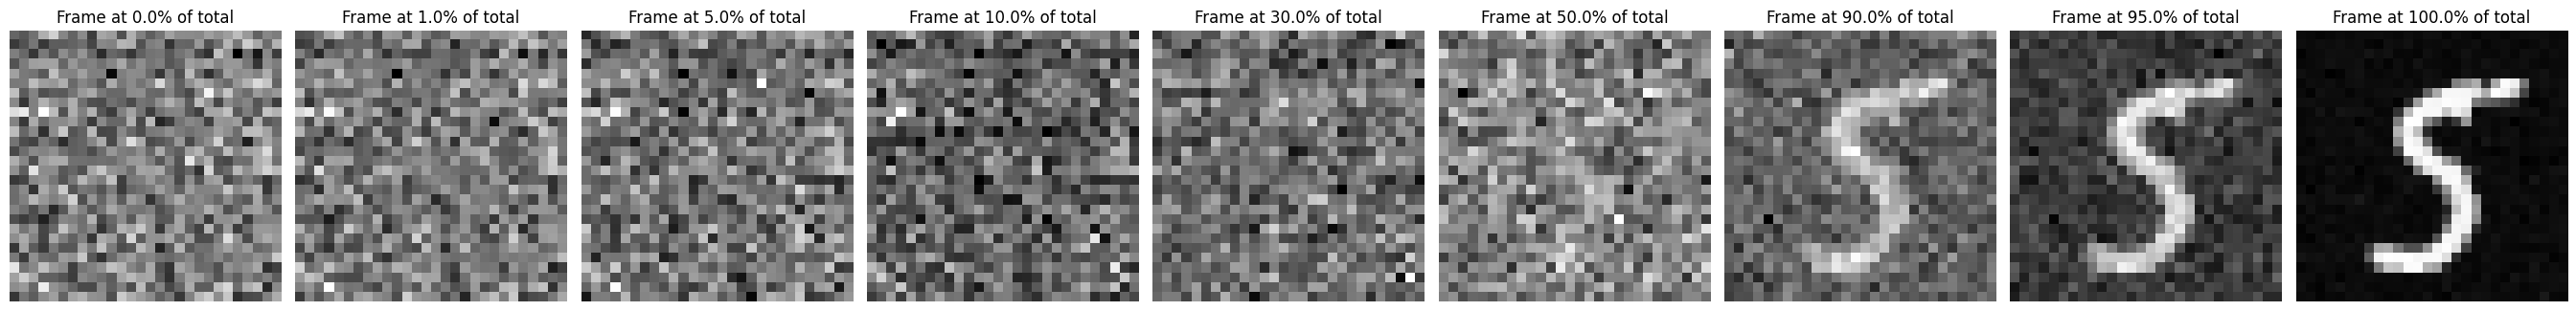

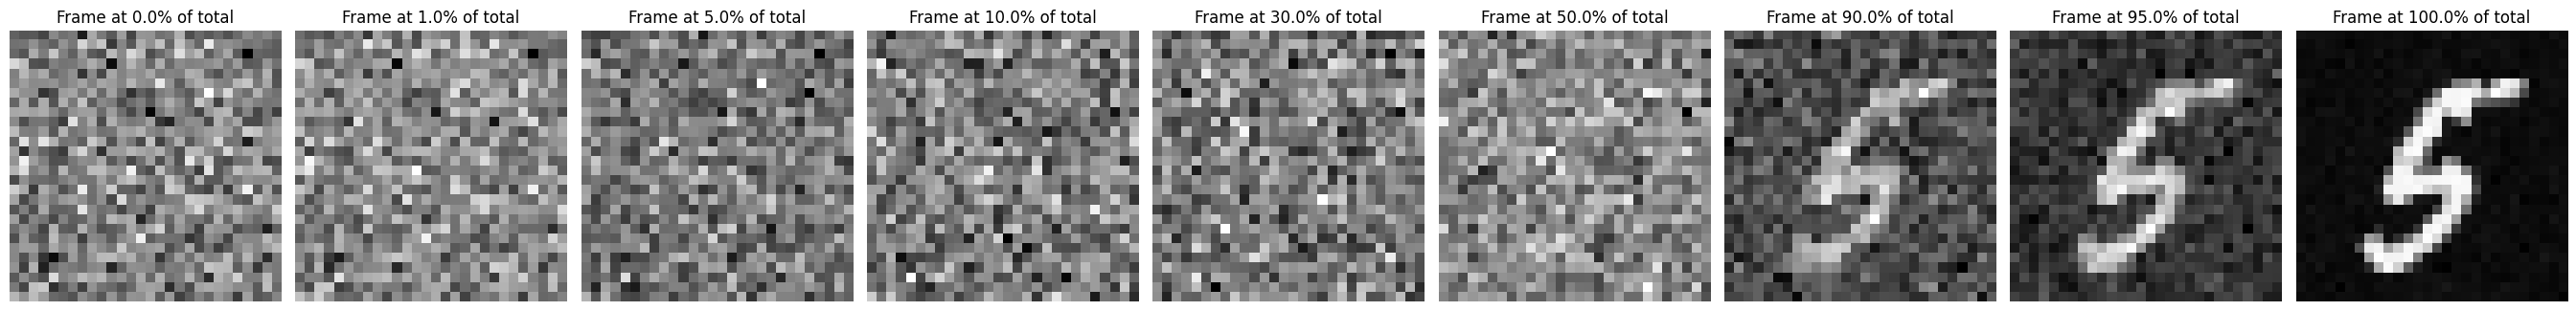

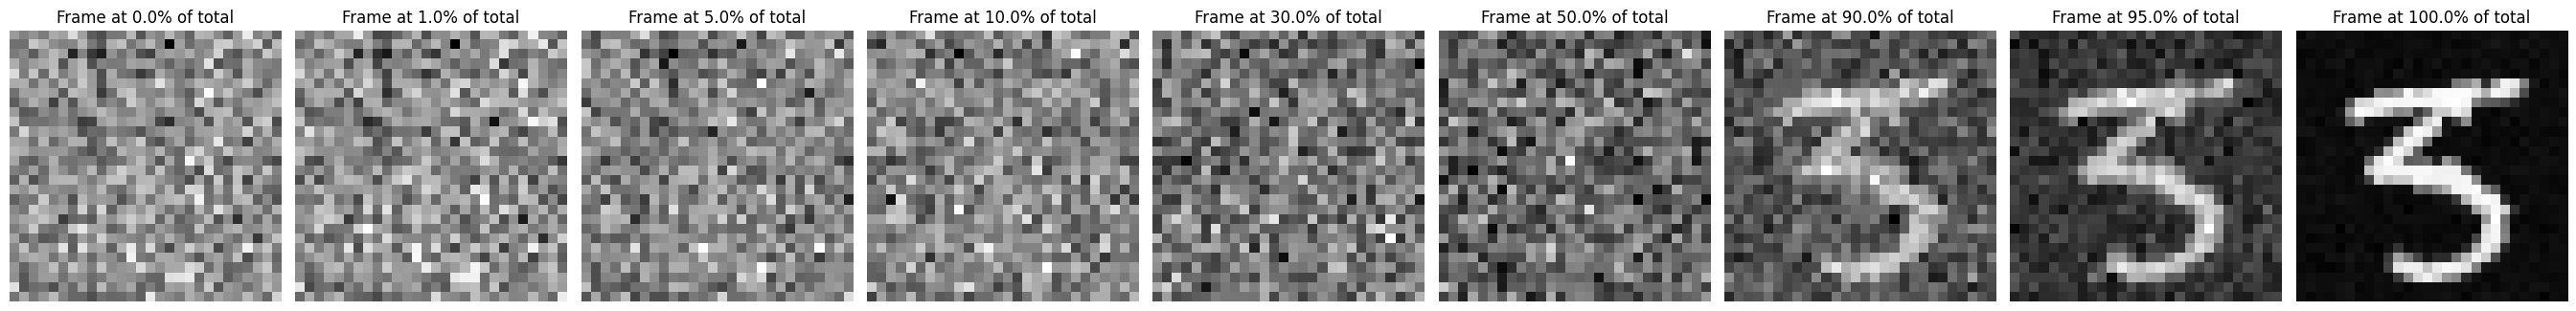

In [23]:
for i in range(30):
    plotter_line(res[1][0][:, i])

In [ ]:
i = 30
plotter_line(res[1][0][:, i])

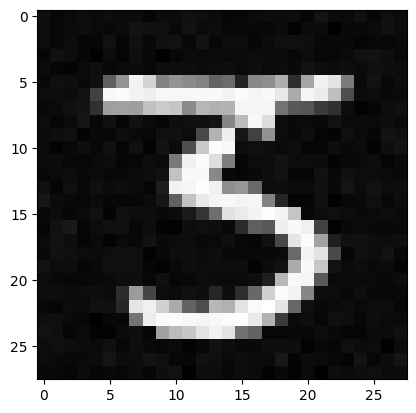

In [24]:
i = 49
plt.imshow(res[0][0][i], cmap="gray")

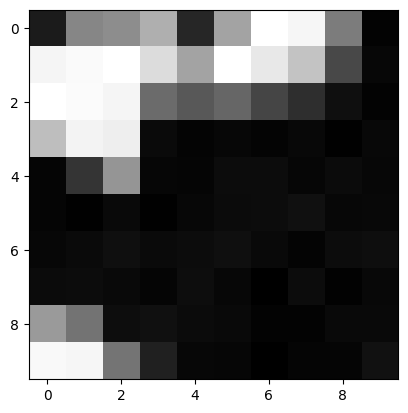

In [18]:
plt.imshow(measure(xi, res[0][0][i], mask), cmap="gray")

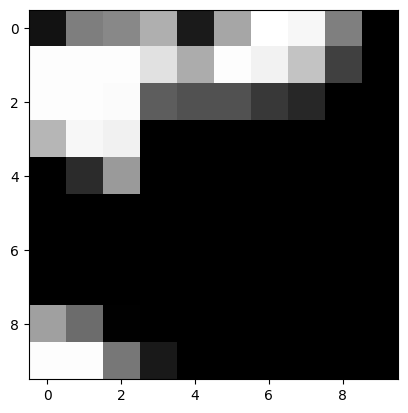

In [19]:
plt.imshow(y, cmap="gray")

In [13]:
import matplotlib.pyplot as plt
def plotter_line(array):
    total_frames = len(array)

    # Define the fractions
    fractions = [0., 0.01, 0.05, .1, 0.3, 0.5, 0.9, .95, 1.]
    n = len(fractions)
    # Create a figure with subplots
    fig, axs = plt.subplots(1, n, figsize=(n*3, n))
    
    for idx, fraction in enumerate(fractions):
        # Calculate the frame index
        frame_index = int(fraction * total_frames)
        
        # Plot the image
        axs[idx].imshow(array[frame_index], cmap="gray")
        axs[idx].set_title(f"Frame at {fraction*100}% of total")
        axs[idx].axis('off')  # Turn off axis labels
        
    plt.tight_layout()
    plt.show()